In [2]:
import pynmea2
import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm
from utils.event_readers import FixedDurationEventReader, FixedSizeEventReader
import cv2
import pandas as pd
import seaborn as sn

from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [3]:
sunset1 = np.load("sunset1_sampled_events_03km_500ms.npy")
sunset2 = np.load("sunset2_sampled_events_03km_500ms.npy")
sunrise = np.load("sunrise_sampled_events_03km_500ms.npy")
morning = np.load("morning_sampled_events_03km_500ms.npy")
night = np.load("night_sampled_events_03km_500ms.npy")
daytime = np.load("daytime_sampled_events_03km_500ms.npy")

traverses = {
    'sunset1': sunset1,
    'sunset2': sunset2,
    'morning': morning,
    'night': night,
    'daytime': daytime,
    'sunrise': sunrise
}


numberOfPlaces = 23

In [4]:
selectedTraverse = "sunset1"

for index, traverseKey in enumerate(traverses):
    comparisonDict = {}
    selectedDict = {}
    for i in range(numberOfPlaces):
        if selectedTraverse != traverseKey:
            comparisonDict[traverseKey + "_" + str(i)] = traverses[traverseKey][i].flatten()
        selectedDict[selectedTraverse + "_" + str(i)] = traverses[selectedTraverse][i].flatten()

    comparisonDf = pd.DataFrame(comparisonDict)
    selectedDf = pd.DataFrame(selectedDict)

<Axes: >

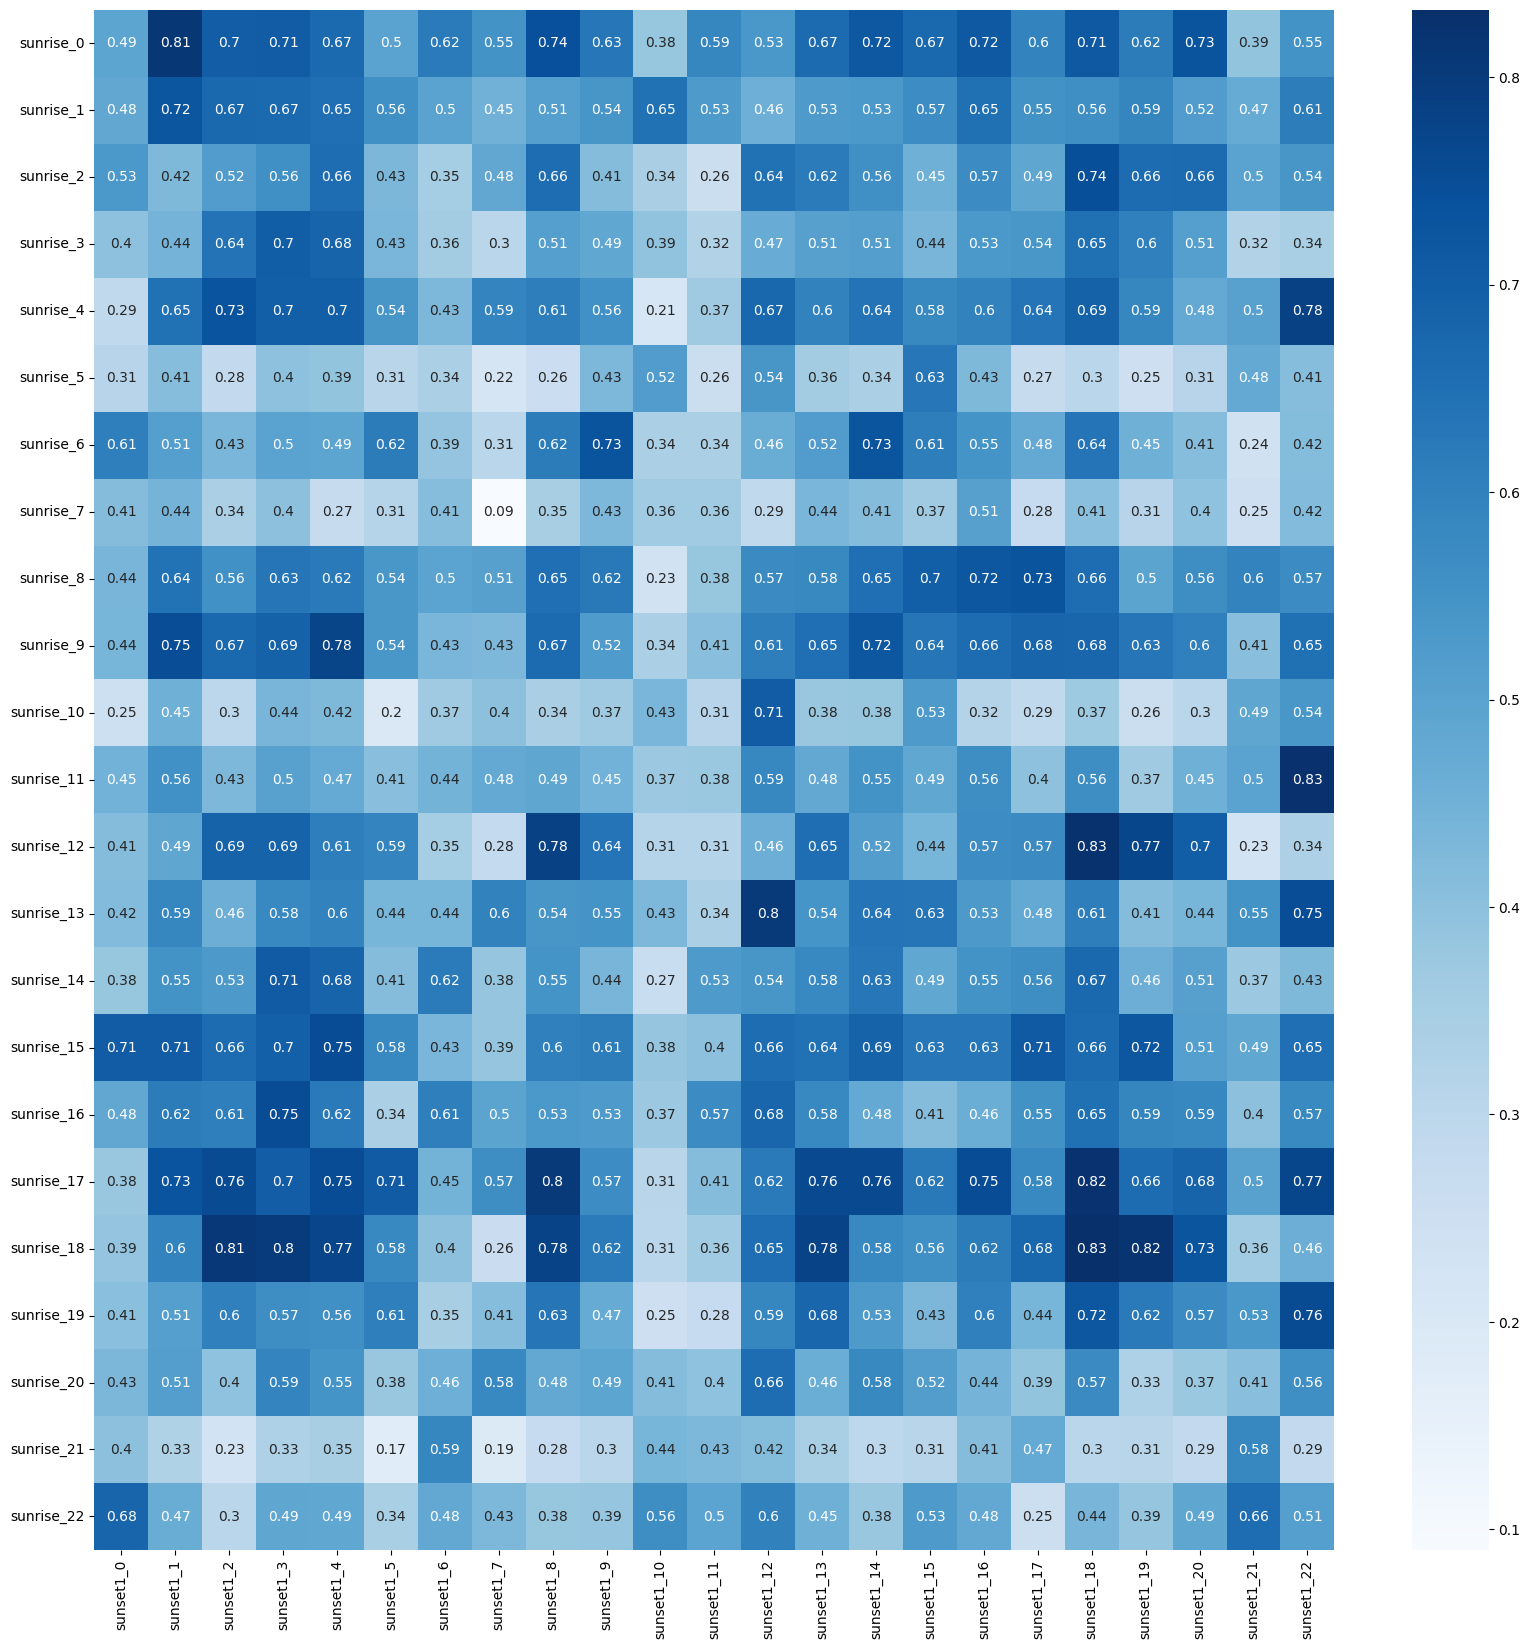

In [5]:
result = pd.concat([comparisonDf, selectedDf], axis=1).corr()
result.head()

result = result[[key for key in selectedDict]].loc[[key for key in comparisonDict]]

plt.figure(figsize=(20,20))
sn.heatmap(result, cmap="Blues", annot=True, )


In [6]:
offsets = np.load("offset_lines.npy", allow_pickle=True).item()

video_paths = {
    'sunset1': "/mnt/e/BrisbaneDataset/ensemble-event-vpr/dvs_vpr_2020-04-21-17-03-03.zip",
    'sunset2': "/mnt/e/BrisbaneDataset/ensemble-event-vpr/dvs_vpr_2020-04-22-17-24-21.zip",
    'daytime': "/mnt/e/BrisbaneDataset/ensemble-event-vpr/dvs_vpr_2020-04-24-15-12-03.zip",
    'morning': "/mnt/e/BrisbaneDataset/ensemble-event-vpr/dvs_vpr_2020-04-28-09-14-11.zip",
    'sunrise': "/mnt/e/BrisbaneDataset/ensemble-event-vpr/dvs_vpr_2020-04-29-06-20-23.zip",
    'night': "/mnt/e/BrisbaneDataset/ensemble-event-vpr/dvs_vpr_2020-04-27-18-13-29.zip"
}

video_beginning = { 
    'sunset1': 1587452582.35,
    'sunset2': 1587540271.65,
    'daytime': 1587705130.80,
    'morning': 1588029265.73,
    'sunrise': 1588105232.91,
    'night': 1587975221.10
}

selectedTimestamps = np.load("selected_points_0.3km.npy")

In [60]:
TIME_WINDOW_SIZE = 500 # Ms
traversesPatterns = {}

for traverse in video_paths:
    print(f"Calculating on traverse: {traverse}")
    eventPatterns = []
    eventPattern = np.array(0)
    windowIndex = 0
    eventReader = FixedDurationEventReader(video_paths[traverse],
                                            duration_ms=TIME_WINDOW_SIZE,
                                            start_index=offsets[traverse]
                                        )
    pbar = tqdm(total=len(selectedTimestamps),
        desc=f"Extracting events on traverse {traverse}",
        position=0)
    

    for timestamp in selectedTimestamps:
        
        while timestamp * 1000 > windowIndex and not None in eventPattern: # Catch StopIteration Exception
            eventPattern = next(eventReader, [None])
            windowIndex += TIME_WINDOW_SIZE
        if not None in eventPattern:
            eventPatterns.append(eventPattern)
        pbar.update(1)
    traversesPatterns[traverse] = eventPatterns
    pbar.close()

Calculating on traverse: sunset1
Will use fixed duration event windows of size 500.00 ms
Output frame rate: 2.0 Hz


Extracting events on traverse sunset1: 100%|██████████| 25/25 [30:52<00:00, 74.09s/it] 


Calculating on traverse: sunset2
Will use fixed duration event windows of size 500.00 ms
Output frame rate: 2.0 Hz


Extracting events on traverse sunset2: 100%|██████████| 25/25 [36:39<00:00, 87.99s/it] 


Calculating on traverse: daytime
Will use fixed duration event windows of size 500.00 ms
Output frame rate: 2.0 Hz


Extracting events on traverse daytime: 100%|██████████| 25/25 [35:02<00:00, 84.09s/it] 


Calculating on traverse: morning
Will use fixed duration event windows of size 500.00 ms
Output frame rate: 2.0 Hz


Extracting events on traverse morning: 100%|██████████| 25/25 [22:49<00:00, 54.77s/it] 


Calculating on traverse: sunrise
Will use fixed duration event windows of size 500.00 ms
Output frame rate: 2.0 Hz


Extracting events on traverse sunrise:  48%|████▊     | 12/25 [10:52<13:33, 62.55s/it]

OSError: [Errno 5] Input/output error

In [12]:
def isInPatternBoundaries(eventList, minimalPoint):
    if len(eventList) == 0:
        return 0
    return minimalPoint < eventList[0][-1]
    
def returnSubset(eventList, minimalPoint, maximalPoint):
    # t, x, y, pol
    eventSubset = []
    for event in eventList:
        if minimalPoint < event[0] and maximalPoint > event[0]:
            eventSubset.append(event)
    return eventSubset

traverses_points = {}
TIME_WINDOW_SIZE = 500 # Ms

for traverse in video_paths:
    windowedPoints = []
    index = 1
    for timestamp in selectedTimestamps:
        print(f'{traverse} : {index} / {len(selectedTimestamps)}')
        t0 = video_beginning[traverse] +  timestamp * 1000 - TIME_WINDOW_SIZE / 2
        t1 = video_beginning[traverse] + timestamp + TIME_WINDOW_SIZE / 2
        
        eventWindow = []
        
        eventReader = FixedSizeEventReader(video_paths[traverse],
                                            num_events=1000000,
                                            start_index=offsets[traverse]
                                        )
        events = next(eventReader, [None])
        while not None in events and not isInPatternBoundaries(events, t0):
            events = next(eventReader, [None])
            print(events[0][0] - t0)
        while not None in events and events[0][0] < t1:
            for event in events:
                if event[0] >= t0 and event[0] < t1:
                    eventWindow.append(event)
            events = next(eventReader)
            
        windowedPoints.append(eventWindow)
        index += 1
    traverses_points[traverse] = windowedPoints            

sunset1 : 1 / 25
Will use fixed size event windows with 1000000 events
Output frame rate: variable
-25742.57914996147
-25739.89457798004
-25736.566938877106
-25733.55515909195
-25730.293560028076
-25728.228097200394
-25726.851535081863
-25725.544924020767
-25724.23114299774
-25723.58101916313
-25723.14462208748
-25720.426815986633
-25718.644995212555
-25717.721811056137
-25716.625809907913
-25715.509871006012
-25713.129878997803
-25710.732856988907
-25706.88606786728
-25705.661691904068
-25704.25057888031
-25701.871423959732
-25699.286942005157
-25696.796331882477
-25694.645498991013
-25693.105506896973
-25691.365753173828
-25689.95279288292
-25688.60041999817
-25687.278506040573
-25686.245145082474
-25685.244338035583
-25683.520544052124
-25681.172477960587
-25679.163729906082
-25677.390918016434
-25676.01417517662
-25673.56757903099
-25671.892135858536
-25670.58852505684
-25668.607311964035
-25666.75907087326
-25665.087218999863
-25663.262095212936
-25661.704849004745
-25660.33217906

KeyboardInterrupt: 

In [59]:
traverse = 'sunset2'
eventReader = FixedSizeEventReader(video_paths[traverse],
                                            num_events=10000,
                                        )

eventList = []
for timestamp in selectedTimestamps:
    found = 0
    endWindow = 0
    print("t0", np.float128(video_beginning[traverse] + timestamp * 1000 - (TIME_WINDOW_SIZE) // 2))
    print("t1", np.float128(video_beginning[traverse] + timestamp * 1000 + (TIME_WINDOW_SIZE) // 2))
    while(not found):
        events = next(eventReader)
        t = events[0][0]
        if t > video_beginning[traverse] + timestamp * 1000 - (TIME_WINDOW_SIZE/1000) // 2:
            print(f"sub {t - video_beginning[traverse]}")
            found = 1


Will use fixed size event windows with 10000 events
Output frame rate: variable
t0 1587566021.6500000954
t1 1587566521.6500000954


KeyboardInterrupt: 

In [50]:
selectedTimestamps

array([ 26.,  58.,  88., 109., 128., 168., 187., 206., 227., 246., 299.,
       345., 394., 415., 436., 458., 477., 499., 520., 540., 566., 607.,
       639., 659., 701.])

In [1]:
import numpy as np

traverses = np.load("traverses_points.npy", allow_pickle=True).item()

In [2]:
def convertListOfEventsIn2DVector(patternList, dimension=[260,346,2]):
    outVector = np.zeros((dimension[0], dimension[1], 3)) # 2 Channels, ON & OFF 
    for event in patternList:
        # Timestamp, X, Y, Polarity
        x = int(event[2])
        y = int(event[1])
        polarity = int(event[3])
        outVector[x][y][polarity] += 1
    return outVector

(115866, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6593.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7337.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6555.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7596.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6898.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..8561.0].


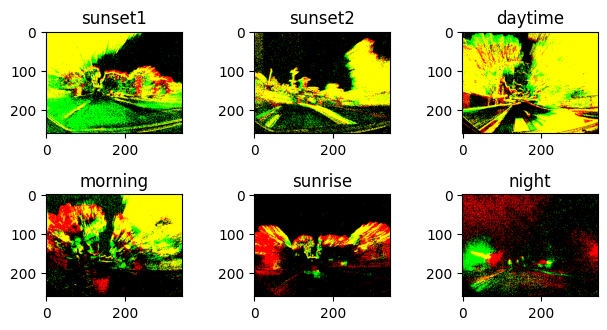

In [4]:
import matplotlib.pyplot as plt

print(traverses['sunrise'][0].shape)

for index, key in enumerate(traverses):
    plt.subplot(3,3,index+1)
    plt.imshow(convertListOfEventsIn2DVector(traverses[key][0]))
    plt.title(key)
plt.tight_layout()